In [4]:
import numpy as np
import pandas as pd
import librosa as lb
import librosa.display
import soundfile as sf
import matplotlib.patches as patch
import matplotlib.pyplot as plt
import IPython.display as ipd
from pathlib import Path
from tqdm.notebook import tqdm
from scipy.io import wavfile
import time
import os
import shutil
from skimage import io
from skimage.color import rgb2gray,rgba2rgb
#https://github.com/iver56/audiomentations ?
%matplotlib inline
CC_ROOT=Path("D:\\KidElectric\\rfcx_kaggle") #Cookiecutter datascience-style project
CC_DATA_OUT=CC_ROOT.joinpath('data').joinpath('interim')

DATA_ROOT = CC_ROOT.joinpath('data')
TRAIN_AUDIO_ROOT = DATA_ROOT.joinpath('raw').joinpath('train')#Update to point to cookiecutter data/raw/train
TEST_AUDIO_ROOT = DATA_ROOT.joinpath('raw').joinpath('test')#Update to point to cookiecutter data/raw/test


df_train = pd.DataFrame({
    "recording_id": [path.stem for path in TRAIN_AUDIO_ROOT.glob("*.flac")],
})

df_test = pd.DataFrame({
    "recording_id": [path.stem for path in TEST_AUDIO_ROOT.glob("*.flac")],
})

df_tp=pd.read_csv(CC_ROOT.joinpath('references').joinpath('train_tp.csv')).set_index('recording_id')

df_fp=pd.read_csv(CC_ROOT.joinpath('references').joinpath('train_fp.csv')).set_index('recording_id')


In [51]:
class params:
    """
    Parameters used for generating spectrograms from audio data
    """
    sr = 48000 #sampling rate

    # Melspectrogram
    n_mels = 128
    fmin = 80
    fmax = 14000  
    n_fft=2048
    hop_length = 512
    
def load_audio(pnfn="", sr=48000):
    y, _ = lb.load(pnfn,
        sr=sr, 
    )
    return y

def compute_melspec(y, params):
    """
    Computes a mel-spectrogram and puts it at decibel scale
    Arguments:
        y {np array} -- signal
        params {AudioParams} -- Parameters to use for the spectrogram. Expected to have the attributes sr, n_mels, f_min, f_max
    Returns:
        np array -- Mel-spectrogram
    """
    melspec = lb.feature.melspectrogram(
        y, sr=params.sr, n_mels=params.n_mels, fmin=params.fmin, fmax=params.fmax, hop_length=params.hop_length,n_fft=params.n_fft
    )
    melspec = lb.power_to_db(melspec).astype(np.float32)
    return melspec

def foreground_background_trfm(y):
    """ Computes foreground / background spectral separation
        Arguments:
        y {np array} -- signal
        
    """
    S_full, phase = lb.magphase(librosa.stft(y))
    
    # Try librosa segmentation example:
    S_filter = lb.decompose.nn_filter(S_full,
                                           aggregate=np.median,
                                           metric='cosine',
                                           width=int(lb.time_to_frames(2, sr=params.sr)))

    # The output of the filter shouldn't be greater than the input
    # if we assume signals are additive.  Taking the pointwise minimium
    # with the input spectrum forces this.
    S_filter = np.minimum(S_full, S_filter)    
    margin_i, margin_v = 2, 10
    power = 2
    mask_i = librosa.util.softmask(S_filter,
                                   margin_i * (S_full - S_filter),
                                   power=power)

    mask_v = librosa.util.softmask(S_full - S_filter,
                                   margin_v * S_filter,
                                   power=power)

    # Once we have the masks, simply multiply them with the input spectrum
    # to separate the components

    S_foreground = mask_v * S_full
    S_background = mask_i * S_full
    return S_full, S_foreground, S_background

def make_box(df_tp,recording):
    t_start=df_tp['t_min'][recording]
    t_stop= df_tp['t_max'][recording]
    f_min= df_tp['f_min'][recording]
    f_max= df_tp['f_max'][recording]
    #matplotlib.patches.Rectangle(xy, width, height, angle=0.0, **kwargs)
    width=t_stop-t_start
    height=f_max-f_min
    xy=(t_start,f_min)
    return t_start, t_stop, f_min, f_max

def has_tp_fp(rec,df_tp,df_fp):
    #Many recordings have both tp and fp data labeled.
    has_tp=False
    has_fp=False
    if rec in df_tp.index:
        has_tp = True
    if rec in df_fp.index:
        has_fp = True
    return has_tp, has_fp

def clip_info(rec,df):
    keep={'species_id':[],'t_min':[],'t_max':[]}
    for key in df.keys():
        if key in keep.keys():
            if isinstance(df[key][rec],pd.core.series.Series):
                keep[key]=[val for val in df[key][rec].values]
            else:
                keep[key].append(df[key][rec])
    return keep

def clip_identity(rec,df_tp,df_fp,start,stop):
    out={'tp_spec':[],'tp':0,
         'fp_spec':[],'fp':0}
    has_fp=False
    has_tp=False
    if rec in df_tp.index:
        info = clip_info(rec,df_tp)
        for i,spec in enumerate(info['species_id']):
            t_min=info['t_min'][i]
            t_max=info['t_max'][i]
            overlap=(t_min < stop and t_min >= start) or (t_max >= start and t_max < stop)
            if overlap == True:
                has_tp=True
                out['tp_spec'].append(spec)
                out['tp']+=1
    
    if rec in df_fp.index:
        info = clip_info(rec,df_fp)
        for i,spec in enumerate(info['species_id']):
            t_min=info['t_min'][i]
            t_max=info['t_max'][i]
            overlap=(t_min < stop and t_min >= start) or (t_max >= start and t_max < stop)
            if overlap == True:
                has_fp=True
                out['fp_spec'].append(spec + 24)
                out['fp']+=1   
    return out

def subtract_median(med,melspec):
    med_sub=np.zeros(melspec.shape)
    for i,col in enumerate(melspec.transpose()):
        med_sub[:,i]=col-med 
    return med_sub

def plot_and_save(full,fore,back,params):
        idx=params.idx
        dat=[full,fore,back]
        for i,d in enumerate(dat):
            plt.subplot(3, 1, i+1)
            lb.display.specshow(lb.amplitude_to_db(d[:, idx], ref=np.max),
                                     y_axis='log', sr=params.sr)
            plt.gca().axis('off') 
            plt.gca().xaxis.set_major_locator(plt.NullLocator())
            plt.gca().yaxis.set_major_locator(plt.NullLocator()) 
        img_pnfn=params.img_pnfn
        print('\tSaving to %s' % img_pnfn)
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.savefig(img_pnfn,pad_inches=0,bbox_inches='tight', transparent=True)
        time.sleep(0.1)
        plt.cla()
        
def save_spectrum_image(y,params,df_tp,df_fp):
    fs=params.sr
    use_root=params.use_root
    full,fore,back = foreground_background_trfm(y)

    # Make spectrogram clips:
    for c,i in enumerate(range(0,params.rec_length,params.clip_dur)):
        start=i
        stop=i+params.clip_dur
        params.idx = slice(*lb.time_to_frames([start,stop], sr=params.sr))
        save_clip=False
        if params.mode == 'TRAIN':            
            clip_id=clip_identity(params.fn,df_tp,df_fp,start,stop)
            if clip_id['tp'] == 1:
                #If clip has one true positive, label that species:
                img_fn='TP_%s_%s_%d.png' % (clip_id['tp_spec'][0],params.fn,c)
                save_clip = True
            if clip_id['tp'] == 0 and clip_id['fp']>=1:
                #If clip has no true positives and at least 1 false positive, label as first false positive species:
                img_fn='FP_%s_%s_%d.png' % (clip_id['fp_spec'][0],params.fn,c)
                save_clip = True
            if clip_id['tp'] == 0 and clip_id['fp']==0:
                #If clip has no TP or FP, label as a unique species id 99:
                img_fn='NP_%s_%s_%d.png' % ('99',params.fn,c)
                save_clip = False # Exclude empty clips for now...
        elif params.mode == 'TEST':
            img_fn='%s_%d' % (params.fn,c)
            save_clip=True
        params.img_pnfn=params.dest.joinpath(img_fn)
        if save_clip == True:
            plot_and_save(full,fore,back,params)





0 of 4727
	 Separating foreground from background...


C:\Users\Brian\anaconda3\envs\fastai2\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\Brian\anaconda3\envs\fastai2\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\Brian\anaconda3\envs\fastai2\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linscaley' parameter of __init__() has been renamed 'linscale' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_45_00204008d_2.png


C:\Users\Brian\anaconda3\envs\fastai2\lib\site-packages\ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_32_00204008d_4.png

1 of 4727
	 Separating foreground from background...


C:\Users\Brian\anaconda3\envs\fastai2\lib\site-packages\ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\Brian\anaconda3\envs\fastai2\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\Brian\anaconda3\envs\fastai2\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\Br

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_003b04435_1.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_47_003b04435_2.png
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\FP_46_003b04435_7.png

2 of 4727
	 Separating foreground from background...


C:\Users\Brian\anaconda3\envs\fastai2\lib\site-packages\ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\Brian\anaconda3\envs\fastai2\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\Brian\anaconda3\envs\fastai2\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\Br

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\train\clip_decomp\TP_14_003bec244_7.png

0 of 1992
	 Separating foreground from background...


C:\Users\Brian\anaconda3\envs\fastai2\lib\site-packages\ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\Brian\anaconda3\envs\fastai2\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\Brian\anaconda3\envs\fastai2\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\Br

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\000316da7_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\000316da7_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\000316da7_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\000316da7_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\000316da7_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\000316da7_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\000316da7_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\000316da7_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\000316da7_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\000316da7_9

1 of 1992
	 Separating foreground from background...


C:\Users\Brian\anaconda3\envs\fastai2\lib\site-packages\ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\Brian\anaconda3\envs\fastai2\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\Brian\anaconda3\envs\fastai2\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\Br

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\003bc2cb2_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\003bc2cb2_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\003bc2cb2_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\003bc2cb2_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\003bc2cb2_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\003bc2cb2_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\003bc2cb2_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\003bc2cb2_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\003bc2cb2_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\003bc2cb2_9

2 of 1992
	 Separating foreground from background...


C:\Users\Brian\anaconda3\envs\fastai2\lib\site-packages\ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\Brian\anaconda3\envs\fastai2\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\Brian\anaconda3\envs\fastai2\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\Br

	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0061c037e_0
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0061c037e_1
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0061c037e_2
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0061c037e_3
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0061c037e_4
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0061c037e_5
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0061c037e_6
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0061c037e_7
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0061c037e_8
	Saving to D:\KidElectric\rfcx_kaggle\data\interim\test\clip_decomp\0061c037e_9


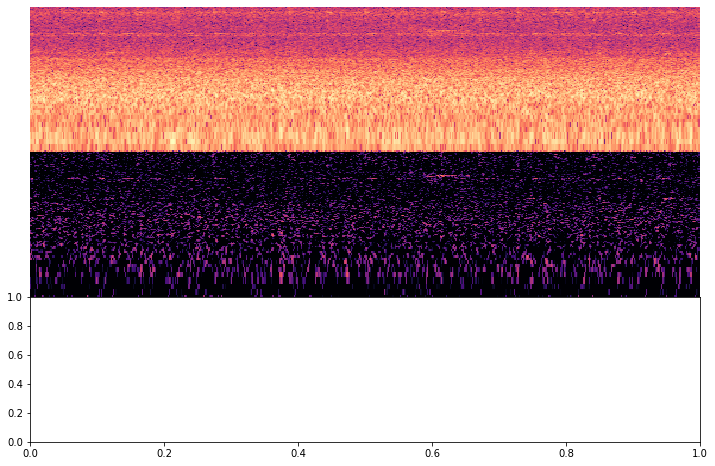

In [52]:
# Make spectrum for each species in recording in train/test:
plt.figure(figsize=(12, 8))
modes = ['TRAIN','TEST']
params.clip_dur=6 # second chunks
params.tp_limit=1 # 1TP max per clip
for mode in modes:
    if mode == 'TEST':
        use_df=df_test
        use_root=TEST_AUDIO_ROOT 
        params.dest=DATA_ROOT.joinpath('interim').joinpath('test').joinpath('clip_decomp')
    elif mode == 'TRAIN':
        use_df=df_train
        use_root=TRAIN_AUDIO_ROOT
        params.dest=DATA_ROOT.joinpath('interim').joinpath('train').joinpath('clip_decomp')
    params.use_root=use_root
        
    if params.dest.exists() == False:
        os.mkdir(params.dest)
    for ii,fn in enumerate(use_df['recording_id'][0:3]):
        pnfn=use_root.joinpath(fn).with_suffix(".flac")
        _,fs=sf.read(pnfn)
        params.sr=fs
        params.mode=mode

        print('\n%d of %d' % (ii, len(use_df['recording_id'])))
        print('\t Separating foreground from background...')
        params.fn=fn
        y = load_audio(pnfn, params.sr)
        params.rec_length=int(y.shape[0]/params.sr)
        save_spectrum_image(y,params,df_tp,df_fp)

In [36]:
fn='0178fe09a'
clip_id=clip_identity(fn,df_tp,df_fp,18,24)
clip_id
# clip_id['tp'] == 0 and clip_id['fp']>=1
clip_id['tp'] == 0 and clip_id['fp']==0

True

In [18]:
params.dest.joinpath('test')


WindowsPath('D:/KidElectric/rfcx_kaggle/data/interim/train/clip_decomp/test')

In [15]:
    for i,spec in enumerate(info['species_id']):
                params.type='TP'
                params.spec=spec
                params.t_min=info['t_min'][i]
                params.t_max=info['t_max'][i]
                save_spectrum_image(y,params)
            if has_fp and params.use_fp == True: #Currently ignoring false positives
                info= clip_info(fn,df_fp)
                print('\tLoading %s' % pnfn)
                y = load_audio(pnfn, params.sr)
                for i,spec in enumerate(info['species_id']):
                    params.type='FP'
                    params.spec=spec
                    params.t_min=info['t_min'][i]
                    params.t_max=info['t_max'][i]
                    save_spectrum_image(y,params)
            else:
                if not has_tp:
                    print('\t no true positives in this clip.')
                if not has_fp:
                    print('\t no false positives in this clip.')
        elif 'TRAIN_FULL' in mode:
            has_tp, has_fp = has_tp_fp(fn,df_tp,df_fp)
            if has_tp and params.use_tp==True:
                info= clip_info(fn,df_tp)
                if len(info['species_id'])==1: #only 1 True positive species per full spectrogram 
                    y = load_audio(fn, params.sr, use_root)
                    params.type='TP'
                    params.spec=info['species_id'][0]
                    save_spectrum_image(y,params)
                else:
                    print('\tMore than one TP detected... excluding.')
            else:
                print('No TP detected ... excluding.')
        elif 'TEST' in mode:
            print('\tLoading %s' % pnfn)
            y = load_audio(pnfn, params.sr)
            save_spectrum_image(y,params)

False

__main__.params

In [30]:
params.use_tp

False

Processing TP_0_00d442df7_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_0_00d442df7_FP_23_16_0_2_13_5_17_18_6.png
Processing TP_0_0268057eb_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_0_0268057eb_FP_12_19_16_0_2_20_18_4_1.png
Processing TP_0_03d77fede_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_0_03d77fede_FP_8_5_20_21_3_0_7_10_2.png
Processing TP_0_067f49f8b_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_0_067f49f8b_FP_4_7_1_8_3_18_19_13_0.png
Processing TP_0_06a0c48c9_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_0_06a0c48c9_FP_19_0_4_3_23_17_22_7_14.png
Processing TP_0_0ea8ea68a_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_0_0ea8ea68a_FP_6_12_14_17_5_0_15_16_9.png
Processing TP_0_157a50231_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_0_157a50231_FP_17_8_21_9_4_19_20_16_0.png
Processing TP_0_251737ef0_FP
	Saving to D:\rf

Processing TP_10_3f3c49ad2_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_10_3f3c49ad2_FP_13_15_2_20_14_3_12_10_5.png
Processing TP_10_3f48c15dc_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_10_3f48c15dc_FP_16_2_15_0_18_3_22_19_10.png
Processing TP_10_3f88e7718_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_10_3f88e7718_FP_20_10_8_23_12_3_7_0_2.png
Processing TP_10_4afa51495_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_10_4afa51495_FP_23_16_21_10_15_4_13_19_22.png
Processing TP_10_4f6e4f097_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_10_4f6e4f097_FP_20_21_12_1_2_19_0_10_17.png
Processing TP_10_51319c540_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_10_51319c540_FP_16_6_0_2_14_21_7_10_1.png
Processing TP_10_5a3f09a5c_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_10_5a3f09a5c_FP_0_10_14_8_15_17_1_11_6.png
Processing TP_10_617412

Processing TP_11_4f600e6f7_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_11_4f600e6f7_FP_1_13_11_19_3_17_10_0_2.png
Processing TP_11_551385b05_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_11_551385b05_FP_0_11_16_4_9_14_18_5_15.png
Processing TP_11_55e48150a_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_11_55e48150a_FP_5_21_20_18_17_12_6_15_11.png
Processing TP_11_579bcf9e0_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_11_579bcf9e0_FP_1_11_19_0_10_13_9_22_14.png
Processing TP_11_5b5218aba_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_11_5b5218aba_FP_20_11_21_17_4_13_15_9_12.png
Processing TP_11_631f97222_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_11_631f97222_FP_14_18_4_11_19_20_23_9_5.png
Processing TP_11_8253e1640_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_11_8253e1640_FP_19_3_11_4_10_1_17_14_6.png
Processing TP_11_8302

Processing TP_12_935e4c9b0_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_12_935e4c9b0_FP_0_15_11_8_1_19_12_9_7.png
Processing TP_12_9425c4b01_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_12_9425c4b01_FP_9_12_22_15_8_3_2_13_21.png
Processing TP_12_9abdbfc9f_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_12_9abdbfc9f_FP_9_12_14_0_23_8_11_15_7.png
Processing TP_12_9d293be93_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_12_9d293be93_FP_15_13_10_21_5_20_18_12_6.png
Processing TP_12_ae4a3b1e2_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_12_ae4a3b1e2_FP_11_19_10_23_6_18_9_12_8.png
Processing TP_12_b45319264_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_12_b45319264_FP_11_15_19_23_21_17_0_12_10.png
Processing TP_12_b7fcfb502_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_12_b7fcfb502_FP_16_15_19_12_22_6_8_11_18.png
Processing TP_12_c22

Processing TP_13_bdc8dd456_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_13_bdc8dd456_FP_8_9_14_13_0_20_23_4_22.png
Processing TP_13_bfacbc575_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_13_bfacbc575_FP_20_13_16_15_18_4_23_8_0.png
Processing TP_13_c3662d871_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_13_c3662d871_FP_10_21_13_20_22_14_16_15_12.png
Processing TP_13_c9899ee73_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_13_c9899ee73_FP_18_23_4_2_12_11_16_13_15.png
Processing TP_13_cb10cd9d9_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_13_cb10cd9d9_FP_4_9_15_6_13_16_1_20_21.png
Processing TP_13_d63d04076_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_13_d63d04076_FP_20_14_10_21_9_8_13_4_23.png
Processing TP_13_d66a5f57b_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_13_d66a5f57b_FP_17_22_9_12_21_11_13_23_10.png
Processing TP_13

Processing TP_14_efbfe6b39_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_14_efbfe6b39_FP_3_14_18_13_21_5_6_8_19.png
Processing TP_14_f702f163c_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_14_f702f163c_FP_5_23_16_3_15_7_1_12_14.png
Processing TP_14_fb3725395_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_14_fb3725395_FP_21_5_12_17_9_14_11_6_16.png
Processing TP_15_015113cad_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_15_015113cad_FP_11_2_15_5_10_4_16_17_6.png
Processing TP_15_078788674_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_15_078788674_FP_17_4_15_12_13_20_0_23_5.png
Processing TP_15_0e29d05ed_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_15_0e29d05ed_FP_23_10_6_19_15_2_17_9_3.png
Processing TP_15_119b154cc_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_15_119b154cc_FP_19_5_21_15_1_20_9_7_8.png
Processing TP_15_11c2c02e5

Processing TP_16_2ce34e1b6_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_16_2ce34e1b6_FP_23_12_3_20_21_8_16_14_7.png
Processing TP_16_2f40810b2_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_16_2f40810b2_FP_3_0_4_10_16_21_20_23_15.png
Processing TP_16_33d0f2685_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_16_33d0f2685_FP_18_4_8_9_16_5_3_2_19.png
Processing TP_16_364e9b5e7_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_16_364e9b5e7_FP_2_11_9_0_23_20_3_16_19.png
Processing TP_16_41e6d9f63_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_16_41e6d9f63_FP_4_5_8_21_16_13_7_3_0.png
Processing TP_16_441707582_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_16_441707582_FP_4_7_15_11_8_23_21_17_16.png
Processing TP_16_49b80ec61_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_16_49b80ec61_FP_15_3_12_10_17_16_13_7_22.png
Processing TP_16_4e5702ed7

Processing TP_17_755d6c7eb_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_17_755d6c7eb_FP_21_23_7_14_12_6_17_9_0.png
Processing TP_17_7583b7c0c_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_17_7583b7c0c_FP_23_1_21_6_20_3_17_7_18.png
Processing TP_17_7878d8306_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_17_7878d8306_FP_15_16_14_8_11_9_1_17_18.png
Processing TP_17_78941c48b_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_17_78941c48b_FP_17_4_8_18_22_23_11_3_16.png
Processing TP_17_7caaeb706_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_17_7caaeb706_FP_17_20_10_0_4_18_12_22_11.png
Processing TP_17_8f3d579c8_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_17_8f3d579c8_FP_17_11_19_2_14_5_12_22_10.png
Processing TP_17_92588122c_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_17_92588122c_FP_18_21_10_20_14_15_19_17_22.png
Processing TP_17_

Processing TP_18_a90c80393_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_18_a90c80393_FP_2_13_17_11_3_18_8_6_21.png
Processing TP_18_ac3da0b30_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_18_ac3da0b30_FP_13_2_11_19_1_3_14_18_12.png
Processing TP_18_b96574294_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_18_b96574294_FP_0_22_20_18_19_5_16_3_21.png
Processing TP_18_b9f3581d5_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_18_b9f3581d5_FP_23_3_5_16_18_9_11_20_12.png
Processing TP_18_bbd9ac366_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_18_bbd9ac366_FP_19_21_16_22_12_18_5_7_20.png
Processing TP_18_c13f3ab95_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_18_c13f3ab95_FP_0_13_18_16_19_5_12_6_15.png
Processing TP_18_cc05ecd08_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_18_cc05ecd08_FP_4_15_12_0_9_22_18_1_16.png
Processing TP_18_d73f

Processing TP_1_0d25045a9_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_1_0d25045a9_FP_9_4_17_11_18_1_23_10_15.png
Processing TP_1_13511f7bd_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_1_13511f7bd_FP_15_1_19_10_9_7_5_0_4.png
Processing TP_1_13c678c1d_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_1_13c678c1d_FP_13_9_16_23_14_1_20_15_8.png
Processing TP_1_13f64f898_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_1_13f64f898_FP_4_13_16_1_20_3_22_14_21.png
Processing TP_1_141675c80_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_1_141675c80_FP_1_19_7_17_20_9_23_3_14.png
Processing TP_1_156b77dfe_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_1_156b77dfe_FP_2_14_22_13_18_1_5_17_4.png
Processing TP_1_16fc37168_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_1_16fc37168_FP_9_10_19_21_1_8_4_6_12.png
Processing TP_1_1ba9ee79a_FP
	Saving to D

Processing TP_20_72ccf4de7_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_20_72ccf4de7_FP_2_6_9_23_17_20_16_7_10.png
Processing TP_20_74a117970_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_20_74a117970_FP_20_21_11_0_1_2_14_12_17.png
Processing TP_20_7b287d190_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_20_7b287d190_FP_12_1_15_0_11_20_21_3_9.png
Processing TP_20_7c858b1f2_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_20_7c858b1f2_FP_23_11_20_21_22_12_1_9_16.png
Processing TP_20_7cd8ce712_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_20_7cd8ce712_FP_2_9_0_8_23_13_5_20_17.png
Processing TP_20_81bcdeb06_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_20_81bcdeb06_FP_19_16_8_9_22_20_5_4_15.png
Processing TP_20_983a13114_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_20_983a13114_FP_15_3_4_20_6_0_1_22_11.png
Processing TP_20_a64b357d4

Processing TP_21_a9868c3d1_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_21_a9868c3d1_FP_3_5_11_23_8_2_6_21_0.png
Processing TP_21_af1d7ef13_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_21_af1d7ef13_FP_20_10_6_12_21_23_5_16_4.png
Processing TP_21_b62292f65_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_21_b62292f65_FP_23_13_0_7_21_2_22_4_3.png
Processing TP_21_bae8eb497_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_21_bae8eb497_FP_17_22_15_14_10_23_9_21_3.png
Processing TP_21_bc18e6dba_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_21_bc18e6dba_FP_20_4_3_22_2_21_10_1_16.png
Processing TP_21_cc8d81b6a_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_21_cc8d81b6a_FP_23_14_21_1_0_18_8_10_19.png
Processing TP_21_d3324f1c0_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_21_d3324f1c0_FP_18_8_7_11_10_21_3_13_4.png
Processing TP_21_db86f881b

Processing TP_23_053aeb7bd_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_053aeb7bd_FP_10_9_11_4_23_17_18_1_6.png
Processing TP_23_09a946316_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_09a946316_FP_20_23_18_19_13_15_6_22_4.png
Processing TP_23_11bafff5d_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_11bafff5d_FP_7_2_5_4_18_1_17_21_23.png
Processing TP_23_160add406_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_160add406_FP_7_3_19_12_4_22_13_10_23.png
Processing TP_23_16553d5cd_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_16553d5cd_FP_10_13_22_0_9_20_23_21_15.png
Processing TP_23_1aa00dc63_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_1aa00dc63_FP_16_9_15_22_3_1_20_8_23.png
Processing TP_23_200656f13_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_200656f13_FP_23_1_14_17_10_13_20_6_16.png
Processing TP_23_226c

Processing TP_23_b55d2f7b4_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_b55d2f7b4_FP_7_20_0_16_8_9_21_5_23.png
Processing TP_23_b988da7d0_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_b988da7d0_FP_2_18_13_22_9_19_23_4_3.png
Processing TP_23_bd62d4fa2_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_bd62d4fa2_FP_4_15_1_9_16_20_3_23_12.png
Processing TP_23_c867bdc27_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_c867bdc27_FP_23_11_7_22_19_5_4_17_12.png
Processing TP_23_c91cae4aa_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_c91cae4aa_FP_6_14_1_23_17_11_21_15_9.png
Processing TP_23_c9bd1f599_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_c9bd1f599_FP_11_22_8_10_5_12_4_3_23.png
Processing TP_23_d09dc9dd5_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_d09dc9dd5_FP_20_7_2_9_18_23_1_16_22.png
Processing TP_23_d32242280

Processing TP_3_050d0ca85_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_3_050d0ca85_FP_3_2_18_15_12_4_21_5_22.png
Processing TP_3_06c44d203_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_3_06c44d203_FP_18_3_22_20_9_6_8_16_19.png
Processing TP_3_0eb2079ea_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_3_0eb2079ea_FP_0_17_20_3_1_22_19_13_10.png
Processing TP_3_133001416_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_3_133001416_FP_6_8_23_5_22_7_14_3_1.png
Processing TP_3_14f6cbe5c_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_3_14f6cbe5c_FP_4_20_12_7_3_16_8_14_11.png
Processing TP_3_163e86660_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_3_163e86660_FP_5_17_1_13_15_3_16_6_14.png
Processing TP_3_2322ec1d3_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_3_2322ec1d3_FP_21_1_22_9_3_8_14_13_7.png
Processing TP_3_288e5d13f_FP
	Saving to D:\

Processing TP_4_4b406a1bc_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_4_4b406a1bc_FP_2_12_10_1_8_13_4_7_21.png
Processing TP_4_4e90ab2fb_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_4_4e90ab2fb_FP_13_9_20_3_16_19_10_4_18.png
Processing TP_4_6666e213d_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_4_6666e213d_FP_13_11_4_19_22_14_5_1_16.png
Processing TP_4_69c09e886_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_4_69c09e886_FP_6_5_4_15_18_11_3_10_7.png
Processing TP_4_6a2b677ce_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_4_6a2b677ce_FP_7_2_13_6_4_20_15_12_1.png
Processing TP_4_7403b8dde_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_4_7403b8dde_FP_5_8_2_0_18_4_10_12_21.png
Processing TP_4_750e35881_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_4_750e35881_FP_6_2_13_11_8_20_7_4_3.png
Processing TP_4_787c0db92_FP
	Saving to D:\rf

Processing TP_5_7b79194b3_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_5_7b79194b3_FP_13_12_21_5_6_11_2_9_7.png
Processing TP_5_871aff1b5_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_5_871aff1b5_FP_2_5_20_13_8_0_16_21_19.png
Processing TP_5_88b5c9c1b_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_5_88b5c9c1b_FP_23_8_5_6_2_0_18_14_16.png
Processing TP_5_8a59b5c31_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_5_8a59b5c31_FP_3_4_22_11_15_23_5_10_19.png
Processing TP_5_945c8d7a8_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_5_945c8d7a8_FP_4_17_6_15_23_20_5_19_1.png
Processing TP_5_9bdc79a14_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_5_9bdc79a14_FP_8_22_5_21_3_20_13_19_0.png
Processing TP_5_a3194950c_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_5_a3194950c_FP_0_15_21_22_1_23_5_20_3.png
Processing TP_5_a461f82cd_FP
	Saving to D:

Processing TP_6_9c9aa37f5_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_6_9c9aa37f5_FP_7_17_2_15_6_16_4_20_9.png
Processing TP_6_9ec0c64c0_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_6_9ec0c64c0_FP_20_21_7_19_17_18_6_10_15.png
Processing TP_6_a5f008080_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_6_a5f008080_FP_19_6_18_16_0_17_11_10_20.png
Processing TP_6_a66d44311_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_6_a66d44311_FP_14_18_2_22_17_10_19_20_6.png
Processing TP_6_ab900ff48_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_6_ab900ff48_FP_4_3_15_6_23_18_21_8_14.png
Processing TP_6_ac7721796_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_6_ac7721796_FP_23_15_22_6_2_10_12_14_20.png
Processing TP_6_af36838f2_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_6_af36838f2_FP_7_6_1_10_2_19_3_15_21.png
Processing TP_6_b056e5bc2_FP
	Savin

Processing TP_7_c68fb36e7_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_7_c68fb36e7_FP_11_9_0_6_4_17_8_5_7.png
Processing TP_7_ccda58237_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_7_ccda58237_FP_20_8_7_14_10_11_15_3_17.png
Processing TP_7_ce05b264d_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_7_ce05b264d_FP_17_15_20_4_7_12_1_3_11.png
Processing TP_7_d1477bf79_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_7_d1477bf79_FP_2_15_10_17_4_13_19_11_7.png
Processing TP_7_d58429096_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_7_d58429096_FP_20_13_8_12_11_18_7_15_1.png
Processing TP_7_dca449f04_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_7_dca449f04_FP_1_22_21_7_0_2_14_3_5.png
Processing TP_7_ea7da0899_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_7_ea7da0899_FP_11_17_19_6_8_1_23_0_7.png
Processing TP_7_f51c0da28_FP
	Saving to D:\r

Processing TP_9_12ec1d4cb_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_9_12ec1d4cb_FP_22_15_9_5_20_0_4_21_19.png
Processing TP_9_1535d0c9b_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_9_1535d0c9b_FP_10_16_4_9_3_12_21_11_20.png
Processing TP_9_247aeccaf_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_9_247aeccaf_FP_12_4_5_11_0_9_16_13_10.png
Processing TP_9_2e6758f3e_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_9_2e6758f3e_FP_8_17_9_3_18_21_1_4_6.png
Processing TP_9_2fc2eca0c_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_9_2fc2eca0c_FP_23_20_11_3_15_5_1_9_12.png
Processing TP_9_349095631_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_9_349095631_FP_23_13_14_11_3_5_22_9_1.png
Processing TP_9_3853bba8e_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_9_3853bba8e_FP_9_23_5_21_18_13_6_12_19.png
Processing TP_9_3b0e345fc_FP
	Saving to D

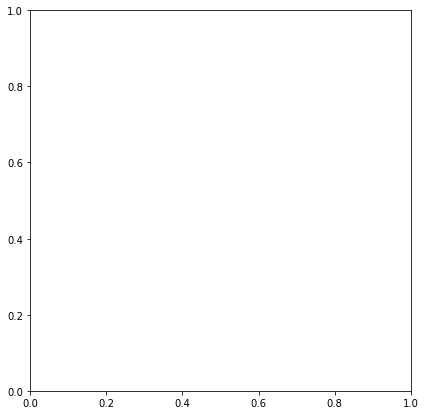

In [109]:
# Combined many FP clips and 1 TP clip into new long clips:

#Generate MANY new long clips--for each TP, select 9 random FP and randomly concatenate together (approximating 60s clip)
dest=TRAIN_AUDIO_ROOT.joinpath('gen_full_tpfp')
if dest.exists()==False:
    os.mkdir(dest)
    #D:\rfcx-species-audio-detection\train\fp_clips\FP_8_00204008d.png
tp=[png for png in TRAIN_AUDIO_ROOT.joinpath('tp_clips').glob('*.png')]
fp=[str(png) for png in TRAIN_AUDIO_ROOT.joinpath('fp_clips').glob('*.png')]
fig, ax = plt.subplots(figsize=(15, 7))
for i,p in enumerate(tp):
    tp_img=rgb2gray(io.imread(p)[:,:,0:3])
    spec=p.parts[-1].split('_')[1]
    rec=p.parts[-1].split('_')[2].split('.')[0]
    use=list(np.random.permutation(24)) # random list of possible FP to include
    use=[s for s in use if s != int(spec)] #exclude FP equal to TP 
    use=use[0:9]
    put_spec=np.random.randint(0,len(use))
    use[put_spec]=int(spec)
    new_fn='TP_%s_%s_FP' % (spec,rec)
    print('Processing %s'% new_fn)
    for j,fp_spec in enumerate(use):
        new_fn=new_fn + '_%d' % fp_spec
        if fp_spec == int(spec):
            #Load TP to this slot
            im=tp_img
        else:
            #Randomly select from available FP of desired species and load im
            fp_rec=df_fp.index[df_fp['species_id']==fp_spec]
            use_fp=fp_rec[np.random.randint(0,len(fp_rec))]
            fpfn=[fn for fn in fp if use_fp in fn][0]
            im=rgb2gray(io.imread(fpfn)[:,:,0:3])
        if j==0:
            a=im
        else:
            a=np.concatenate((a,im),axis=1)
    new_fn = new_fn + '.png'
    img_pnfn=dest.joinpath(new_fn)
    print('\tSaving to %s' % img_pnfn)
    #Plot concatenated spectogram
    plt.imshow(a,cmap='bwr')
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.savefig(img_pnfn,dpi=250,pad_inches=0,bbox_inches='tight', transparent=True)
    time.sleep(0.1)
    plt.cla()

In [103]:
fp_spec=23
spec=3
use0=list(np.random.permutation(24)) # random list of possible FP to include
use1=[s for s in use0 if s != int(spec)] #exclude FP equal to TP 
use2=use1[0:9]
put_spec=np.random.randint(0,len(use2))
use3=use2
use3[put_spec]=spec
use3

[2, 17, 20, 21, 0, 9, 22, 3, 16]

In [89]:
[s for s in use0 if s != int(spec)]

[11,
 17,
 21,
 22,
 8,
 15,
 2,
 12,
 23,
 16,
 20,
 9,
 4,
 19,
 14,
 13,
 1,
 18,
 6,
 10,
 0,
 5,
 7]

In [ ]:
#Copy tp and fp into species-specific folders:
start_dirs=['tp_clips','fp_clips']
for d in start_dirs:
    src=TRAIN_AUDIO_ROOT.joinpath(d)
    pngs=[png for png in src.glob('*.png')]
    for png in pngs:
        fn=png.parts[-1]
        spec=fn.split('_')[1]
        dest = TRAIN_AUDIO_ROOT.joinpath('spec').joinpath(spec)
        if dest.exists()==False:
            os.mkdir(dest)
        #print('From %s to %s' % (png,dest))
        shutil.copy(str(png),dest)
print('Finished')

In [ ]:
#Move FP clips spectrograms from species-based folders into tp_clips data folder:
for spec in np.unique(df_fp['species_id']):
    path = TRAIN_AUDIO_ROOT.joinpath('%d' % spec)
    pngs=[png for png in path.glob('*.png')]
    for png in pngs:
        fn=png.parts[-1]
        tp=fn.split('_')[0]
        if tp == 'FP':
            print(png)
            shutil.move(str(png),str(TRAIN_AUDIO_ROOT.joinpath('tp_clip')))

In [ ]:
#Copy tp clips into tp_clips:
start_dirs=['tp_clips_and_full',]
for d in start_dirs:
    src=TRAIN_AUDIO_ROOT.joinpath(d)
    pngs=[png for png in src.glob('*.png')]
    for png in pngs:
        fn=png.parts[-1]
        p=fn.split('_')
        if len(p) >= 4:
            is_full=p[3] == 'full.png'
        dest = TRAIN_AUDIO_ROOT.joinpath('tp_clips').joinpath(fn)
        if not is_full:`
            print('From %s to %s' % (png,dest))
            shutil.copy(str(png),dest)
print('Finished')